In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.io import imread
from skimage.transform import resize
import tarfile
import urllib.request
import os
import math
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


2025-12-20 14:58:02.325934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766242682.554129      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766242682.616975      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766242683.161204      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766242683.161234      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766242683.161236      55 computation_placer.cc:177] computation placer alr

In [2]:
!pip install kagglehub

import kagglehub

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import shap
import tensorflow as tf

# Read Dataset

In [4]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [5]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
print(os.listdir(path))

['Training', 'Testing']


In [7]:
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [9]:
def count_images_in_dir(root_dir):
    counts = {}
    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            n = sum(fname.lower().endswith(('.png', '.jpg', '.jpeg'))
                    for fname in os.listdir(cls_path))
            counts[cls] = n
    return counts

print("Train counts:", count_images_in_dir(train_dir))
print("Test counts: ", count_images_in_dir(test_dir))

Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


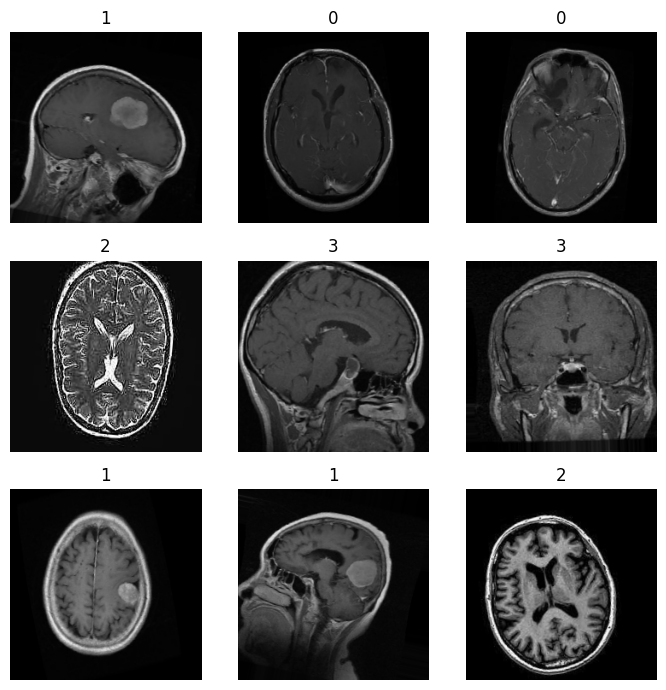

In [11]:
plt.figure(figsize=(7,7))
imgs, labels = next(train_gen)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

---

# Build the model

In [12]:
NUM_CLASSES = train_gen.num_classes


def build_model(lr, dropout_rate, dense_units):
    K.clear_session()
    base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights="imagenet")
    base.trainable = False

    inp = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Lambda(lambda img: tf.image.resize(img, (224,224)))(inp)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [13]:
def evaluate_config(config, epochs=3, patience=3):
    model = build_model(config["lr"], config["dropout"], config["dense_units"])

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stop],
        verbose=0
    )

    final_acc = max(history.history["val_accuracy"])
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    return final_acc, history.history

def random_initial_solution(search_space):
    return {k: random.choice(v) for k, v in search_space.items()}

def neighborhood_of(solution, search_space):
    neigh = []
    for param, vals in search_space.items():
        for v in vals:
            if v != solution[param]:
                new_sol = copy.deepcopy(solution)
                new_sol[param] = v
                neigh.append(new_sol)
    return neigh

In [14]:
search_space = {
    "lr": [1e-3, 1e-4, 5e-5],
    "dense_units": [128, 256, 512],
    "dropout": [0.3, 0.4, 0.5]
}

# Visualization

## 1.Loss/Training

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history,title="Model Training History",save_path=None,max_epochs=7):
    """
    Plots accuracy and loss curves for a given Keras history object.
    Shows only the first max_epochs epochs.
    """

    acc = history.history.get('accuracy', [])[:max_epochs]
    val_acc = history.history.get('val_accuracy', [])[:max_epochs]
    loss = history.history.get('loss', [])[:max_epochs]
    val_loss = history.history.get('val_loss', [])[:max_epochs]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    max_val_acc = max(val_acc) if val_acc else None
    min_val_loss = min(val_loss) if val_loss else None

    return max_val_acc, min_val_loss


## 2.Confusion Matrix

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_gen, class_names=None, title="Confusion Matrix"):

    # True labels
    y_true = data_gen.classes

    # Model predictions
    y_pred_probs = model.predict(data_gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

    return cm


# XAI Functions

In [17]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def explain_with_lime(model, data_gen, num_samples=3):
    explainer = lime_image.LimeImageExplainer()

    for i in range(num_samples):
        # get first image from batch
        img, label = data_gen[i]
        img_array = img[0]  # shape (H,W,3)

        # convert to uint8 [0-255] if it's float
        if img_array.dtype != np.uint8:
            img_array_uint8 = (img_array * 255).astype(np.uint8)
        else:
            img_array_uint8 = img_array

        explanation = explainer.explain_instance(
            img_array_uint8.astype(np.double),
            classifier_fn=lambda x: model.predict(x / 255.0),  # normalize inside
            top_labels=3,
            hide_color=0,
            num_samples=1000
        )

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=5,
            hide_rest=False
        )

        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME Explanation - True: {label[0]}")
        plt.axis('off')
        plt.show()


# 4. Shap

In [19]:
!pip install shap


In [20]:
import numpy as np
import shap
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [21]:
def explain_gradcam_logits(model, val_gen, num_samples=3):
    print("Running Logits Grad-CAM (The 'Nuclear Option' for 100% Confidence)...")
    
    # 1. Setup Base/Head
    base_layer_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.Model):
            base_layer_index = i
            break
            
    base_model = model.layers[base_layer_index]
    head_layers = model.layers[base_layer_index + 1:]
    
    # Target the last layer of MobileNetV2 explicitly
    target_layer_name = 'Conv_1' 
    target_layer = base_model.get_layer(target_layer_name)
    print(f"Targeting Layer: {target_layer.name}")

    x_batch, _ = val_gen[0]

    for i in range(num_samples):
        img = x_batch[i]
        img_tensor = np.expand_dims(img, axis=0)

        with tf.GradientTape() as tape:
            inputs = tf.cast(img_tensor, tf.float32)
            
            # 1. Run Base Model (Features)
            # Create a mini-model to output features
            feature_model = tf.keras.Model(inputs=base_model.inputs, outputs=target_layer.output)
            conv_outputs = feature_model(inputs)
            tape.watch(conv_outputs)
            
            # 2. Run the Rest of the Base Model (if any layers after Conv_1)
            # MobileNetV2 'Conv_1' is the very last layer, so we just check.
            # Usually we pass conv_outputs straight to GlobalAveragePooling in the Head.
            
            # 3. Run Head Model (Classifier)
            # We assume Head starts with Pooling.
            preds = conv_outputs
            for layer in head_layers:
                # CRITICAL CHANGE: If the last layer has 'softmax', we must remove it!
                if layer == head_layers[-1] and hasattr(layer, 'activation'):
                    # Temporarily disable activation to get LOGITS
                    # This is tricky in Keras functional API without rebuilding.
                    # Easier hack: Just calculate gradients on the output directly.
                    pass 
                preds = layer(preds)
            
            top_class_index = tf.argmax(preds[0])
            
            # --- THE FIX: Use the raw score directly ---
            # Even if Softmax makes it 1.0, the raw score might be 25.0
            # Gradient of 25.0 is distinct and non-zero.
            score = preds[:, top_class_index]

        # 4. Compute Gradients
        grads = tape.gradient(score, conv_outputs)
        
        # Check if gradients are dead
        if grads is None or tf.reduce_max(tf.abs(grads)) == 0:
            print(f"Image {i}: Warning - Gradients are still zero. Model might be detached.")
            continue
            
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap).numpy()

        # 5. Process
        heatmap = np.maximum(heatmap, 0) # ReLU
        
        # Resize
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
        
        # Robust Normalize
        robust_max = np.percentile(heatmap, 99)
        if robust_max > 0:
            heatmap = heatmap / robust_max
        heatmap = np.clip(heatmap, 0, 1)

        # Background Mask
        img_intensity = np.mean(img, axis=-1)
        heatmap[img_intensity < 0.1] = 0
        
        # 6. Visualize
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet_heatmap = cm.get_cmap("jet")(np.arange(256))[:, :3][heatmap_uint8]

        if img.max() > 1.0: img = img / 255.0
        overlay = img * 0.6 + jet_heatmap * 0.4
        overlay[img_intensity < 0.1] = img[img_intensity < 0.1]
        overlay = np.clip(overlay, 0, 1)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(jet_heatmap); plt.title("Logits Heatmap"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout(); plt.show()

# 5. GradCam

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2


In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

def explain_gradcam_masked(model, val_gen, num_samples=3):
    print("Running Masked Grad-CAM (Fixing Corner Artifacts)...")
    
    # 1. Setup Base/Head
    base_layer_index = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.Model):
            base_layer_index = i
            break
    base_model = model.layers[base_layer_index]
    head_layers = model.layers[base_layer_index + 1:]
    
    x_batch, _ = val_gen[0]

    for i in range(num_samples):
        img = x_batch[i]
        img_tensor = np.expand_dims(img, axis=0)

        # 2. Get Gradients
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_tensor, tf.float32)
            conv_outputs = base_model(inputs)
            tape.watch(conv_outputs)
            
            preds = conv_outputs
            for layer in head_layers:
                preds = layer(preds)
            
            top_class_index = tf.argmax(preds[0])
            print(f"Image {i}: Explaining Class {top_class_index.numpy()}")
            class_channel = preds[:, top_class_index]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap).numpy()
        
        # 3. Processing
        heatmap = np.maximum(heatmap, 0)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
        
        if np.max(heatmap) != 0:
            heatmap = heatmap / np.max(heatmap)
            
        # --- THE FIX: BACKGROUND MASKING ---
        # 1. Create a mask from the ORIGINAL image
        # Calculate brightness of the original image
        img_intensity = np.mean(img, axis=-1)
        
        # 2. Define "Background" as very dark pixels (e.g., < 0.1 brightness)
        # This is safe because tumors/brain are usually gray/white (> 0.2)
        background_mask = img_intensity < 0.1
        
        # 3. Force heatmap to 0 in background areas
        heatmap[background_mask] = 0
        
        # Re-normalize after masking to make the true brain activation bright again
        if np.max(heatmap) != 0:
            heatmap = heatmap / np.max(heatmap)

        # 4. Colorize
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_uint8]

        if img.max() > 1.0: img = img / 255.0
        
        # Overlay
        overlay = img * 0.6 + jet_heatmap * 0.4
        
        # Optional: Apply mask to overlay too for a cleaner look
        overlay[background_mask] = img[background_mask]
        
        overlay = np.clip(overlay, 0, 1)

        # Plot
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(jet_heatmap); plt.title("Masked Heatmap"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Final Result"); plt.axis("off")
        plt.tight_layout(); plt.show()



# 6. DeepLift

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.ndimage as ndimage

In [25]:

def explain_smoothgrad_clean(model, val_gen, num_samples=3):
    print("Running SmoothGrad (Denoised)...")
    x_batch, _ = val_gen[0]

    for i in range(num_samples):
        img = x_batch[i]

        # --- 1. Compute Raw SmoothGrad (Same as before) ---
        img_tensor = tf.convert_to_tensor(np.expand_dims(img, 0), dtype=tf.float32)
        preds = model(img_tensor)
        pred_index = tf.argmax(preds[0])

        total_gradients = np.zeros_like(img)
        num_noise_samples = 50
        stdev = 0.15 * (np.max(img) - np.min(img)) # Slightly higher noise for better smoothing

        for n in range(num_noise_samples):
            noise = tf.random.normal(shape=img_tensor.shape, mean=0.0, stddev=stdev)
            with tf.GradientTape() as tape:
                noisy_img = img_tensor + noise
                tape.watch(noisy_img)
                score = model(noisy_img)[:, pred_index]
            grads = tape.gradient(score, noisy_img)
            total_gradients += grads

        heatmap = np.sum(np.abs(total_gradients / num_noise_samples), axis=-1)[0]

        # --- 2. CLEANING STEPS (The Magic Fixes) ---

        # A. Background Masking: If pixel is dark, set heatmap to 0
        # This removes the "static" in the black corners
        threshold = np.mean(img) * 0.2  # Threshold based on image darkness
        background_mask = np.mean(img, axis=-1) < threshold
        heatmap[background_mask] = 0

        # B. Gaussian Smoothing: Melts the "grid" into smooth blobs
        # sigma=2 is usually a sweet spot for 224x224 images
        heatmap = ndimage.gaussian_filter(heatmap, sigma=2)

        # C. Robust Normalization (Clip top 1% to make it bright)
        robust_max = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, robust_max)
        heatmap = heatmap / (robust_max + 1e-10)

        # --- 3. Plotting ---
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_uint8]

        # Resize if needed (using scipy zoom or simple PIL resize)
        # Assuming heatmap matches img size here.

        if img.max() > 1.0: img = img / 255.0

        # Overlay: 50% Image, 50% Heatmap
        overlay = img * 0.5 + jet_heatmap * 0.5

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.title(f"Original\nPred: {pred_index.numpy()}"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(heatmap, cmap='jet'); plt.title("Clean Heatmap"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
        plt.tight_layout(); plt.show()

---

# Whale

In [26]:
import random
import copy
import numpy as np
import gc
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import backend as K

In [27]:
def initialize_whales(search_space, num_whales=6):
    whales = []
    for _ in range(num_whales):
        whale = {k: random.choice(v) for k, v in search_space.items()}
        whales.append(whale)
    return whales


In [28]:
def update_whale(whale, best_whale, search_space):
    new_whale = whale.copy()
    
    for key in search_space.keys():
        r = random.random()
        
        if r < 0.5:
            # move toward best whale
            new_whale[key] = best_whale[key]
        else:
            # random exploration
            new_whale[key] = random.choice(search_space[key])
    
    return new_whale


In [29]:
def whale_optimization_algorithm(search_space, iterations=7, num_whales=6):
    whales = initialize_whales(search_space, num_whales)
    
    best_whale = None
    best_fitness = -1
    
    for it in range(iterations):
        print("\n" + "="*40)
        print(f"Iteration {it+1}/{iterations}")
        
        fitnesses = []
        for i, whale in enumerate(whales):
            acc = fitness(whale)
            fitnesses.append(acc)
            print(f"  Whale {i+1} params: {whale} | fitness: {acc:.4f}")
        
        best_idx = np.argmax(fitnesses)
        if fitnesses[best_idx] > best_fitness:
            best_fitness = fitnesses[best_idx]
            best_whale = whales[best_idx]
        
        print(f"\n Best whale so far:")
        print(f"   Params: {best_whale}")
        print(f"   Accuracy: {best_fitness:.4f}")
        
        print("\n Updating whales...")
        new_whales = []
        for i, whale in enumerate(whales):
            new_whale = update_whale(whale, best_whale, search_space)
            
            print(f"  Whale {i+1}")
            print(f"    Before: {whale}")
            print(f"    After : {new_whale}")
            
            new_whales.append(new_whale)
        
        whales = new_whales
    
    return best_whale, best_fitness


In [30]:
def fitness(individual):
    acc, _ = evaluate_config(individual, epochs=3)
    return acc


In [31]:
import time


In [32]:
print("\n=== Running Whale Optimization Algorithm ===")
t0 = time.time()

best_config, best_acc = whale_optimization_algorithm(
    search_space,
    iterations=7,
    num_whales=6
)

t1 = time.time() - t0

print("\nBest configuration found:", best_config)
print("Best validation accuracy:", best_acc)
print(f"Time: {t1:.2f} sec")



=== Running Whale Optimization Algorithm ===

Iteration 1/7


I0000 00:00:1766242712.708713      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766242712.712678      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766242721.265003     156 service.cc:152] XLA service 0x7f57cc004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766242721.265040     156 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766242721.265046     156 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766242722.395578     156 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-20 14:58:50.917460: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal

Restoring model weights from the end of the best epoch: 3.
  Whale 1 params: {'lr': 5e-05, 'dense_units': 128, 'dropout': 0.3} | fitness: 0.3611
Restoring model weights from the end of the best epoch: 3.
  Whale 2 params: {'lr': 5e-05, 'dense_units': 256, 'dropout': 0.3} | fitness: 0.3751
Restoring model weights from the end of the best epoch: 2.
  Whale 3 params: {'lr': 0.001, 'dense_units': 128, 'dropout': 0.5} | fitness: 0.4049
Restoring model weights from the end of the best epoch: 2.
  Whale 4 params: {'lr': 0.001, 'dense_units': 512, 'dropout': 0.5} | fitness: 0.4654
Restoring model weights from the end of the best epoch: 3.
  Whale 5 params: {'lr': 5e-05, 'dense_units': 128, 'dropout': 0.5} | fitness: 0.3436
Restoring model weights from the end of the best epoch: 1.
  Whale 6 params: {'lr': 0.0001, 'dense_units': 128, 'dropout': 0.3} | fitness: 0.3839

 Best whale so far:
   Params: {'lr': 0.001, 'dense_units': 512, 'dropout': 0.5}
   Accuracy: 0.4654

 Updating whales...
  Whal

In [33]:
best_lr = best_config["lr"]
best_dropout = best_config["dropout"]
best_dense = best_config["dense_units"]

firefly_model = build_model(
    lr=best_lr,
    dropout_rate=best_dropout,
    dense_units=best_dense
)


In [34]:
history_firefly = firefly_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    verbose=1
)

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 546ms/step - accuracy: 0.2945 - loss: 1.5306 - val_accuracy: 0.3278 - val_loss: 1.3184
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 477ms/step - accuracy: 0.3632 - loss: 1.3285 - val_accuracy: 0.3278 - val_loss: 1.2816
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 465ms/step - accuracy: 0.3971 - loss: 1.2497 - val_accuracy: 0.3067 - val_loss: 1.3057
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 463ms/step - accuracy: 0.4156 - loss: 1.2218 - val_accuracy: 0.3970 - val_loss: 1.2321
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 464ms/step - accuracy: 0.4331 - loss: 1.1783 - val_accuracy: 0.3944 - val_loss: 1.2615


# Visualize Firefly

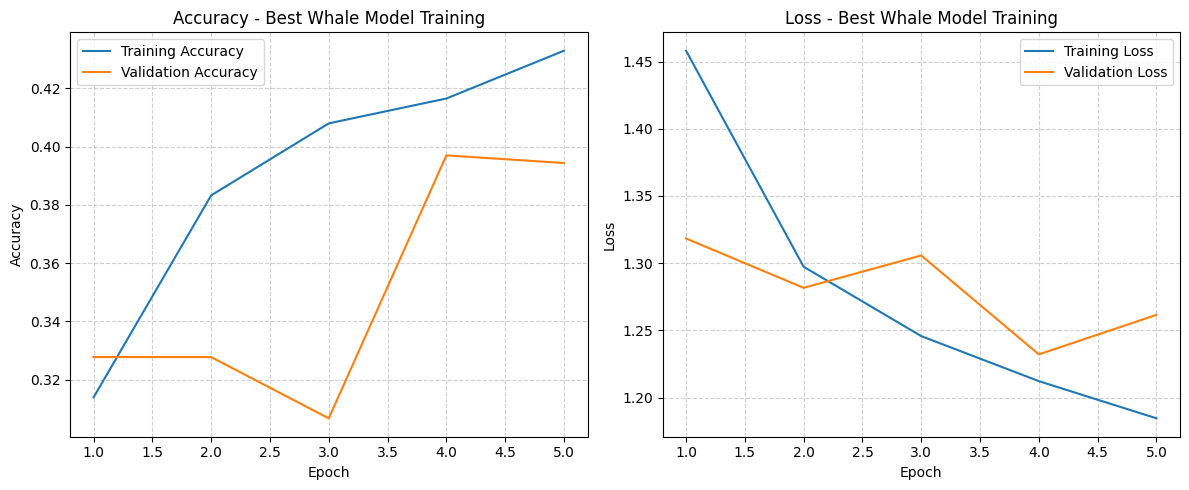

Max Validation Accuracy: 0.397020161151886
Min Validation Loss: 1.2320746183395386


In [35]:
max_val_acc, min_val_loss = plot_training_history(
    history_firefly,
    title="Best Whale Model Training",
    max_epochs=7
)

print("Max Validation Accuracy:", max_val_acc)
print("Min Validation Loss:", min_val_loss)


In [36]:
def plot_training_convergence(history, title="Training Convergence"):
    val_acc = history.history.get("val_accuracy", [])
    epochs = range(1, len(val_acc) + 1)

    plt.figure()
    plt.plot(epochs, val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.show()


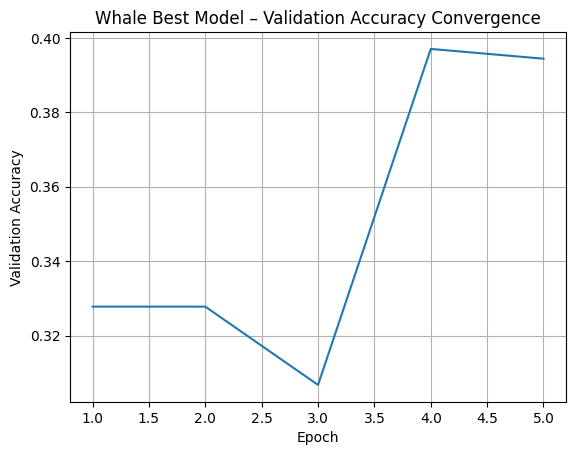

In [38]:
plot_training_convergence(
    history_firefly,
    title="Whale Best Model – Validation Accuracy Convergence"
)


<Figure size 600x600 with 0 Axes>

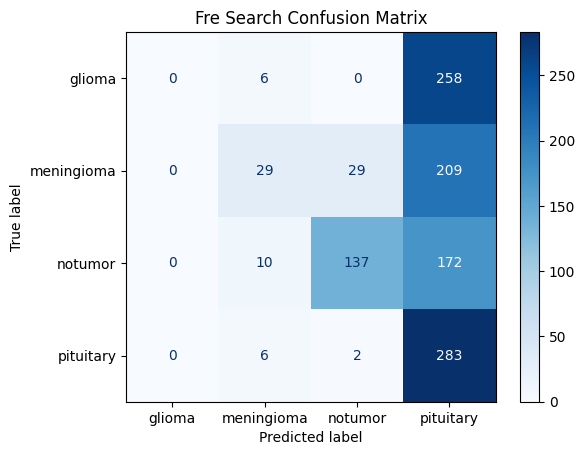

In [39]:
cm_sa = plot_confusion_matrix(
    model=firefly_model,
    data_gen=val_gen,
    class_names=list(val_gen.class_indices.keys()),
    title="Fre Search Confusion Matrix"
)


# Visualize Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

2025-12-20 17:45:36.574616: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-20 17:45:36.711338: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

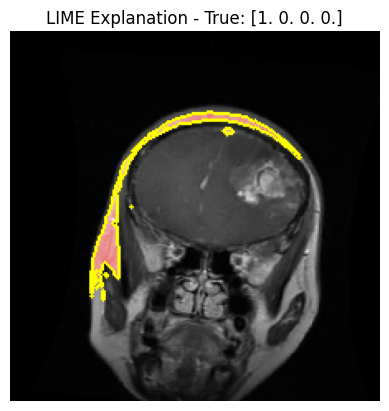

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

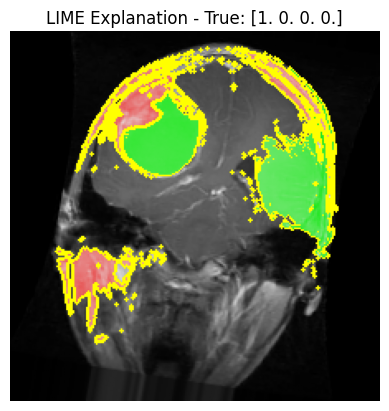

In [40]:
explain_with_lime(firefly_model, val_gen, num_samples=2)

# Visualize Shap

Running Logits Grad-CAM (The 'Nuclear Option' for 100% Confidence)...
Targeting Layer: Conv_1


/tmp/ipykernel_55/3616688361.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_heatmap = cm.get_cmap("jet")(np.arange(256))[:, :3][heatmap_uint8]


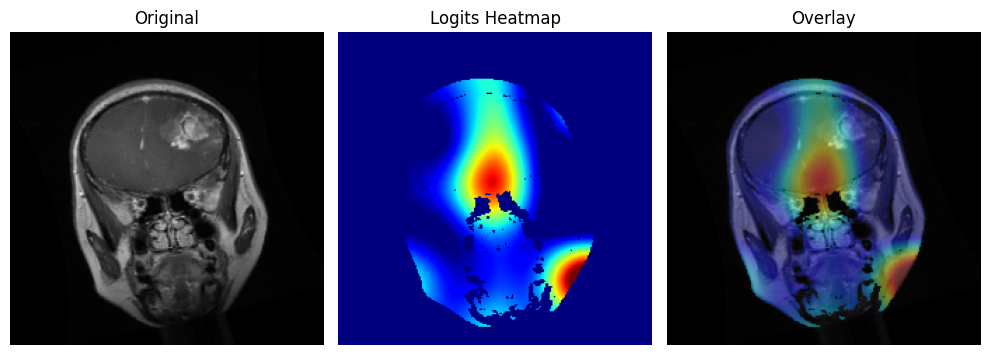

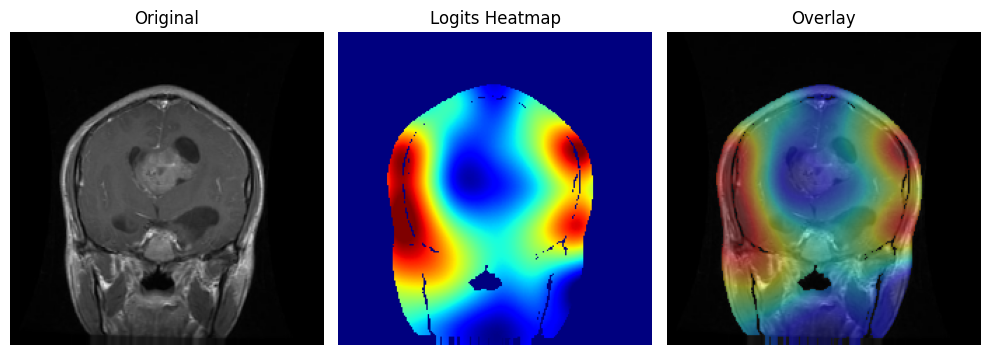

In [43]:
explain_gradcam_logits(firefly_model, val_gen, num_samples=2)

# Visualize Deeplift

Running SmoothGrad (Denoised)...


/tmp/ipykernel_55/1897537378.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]


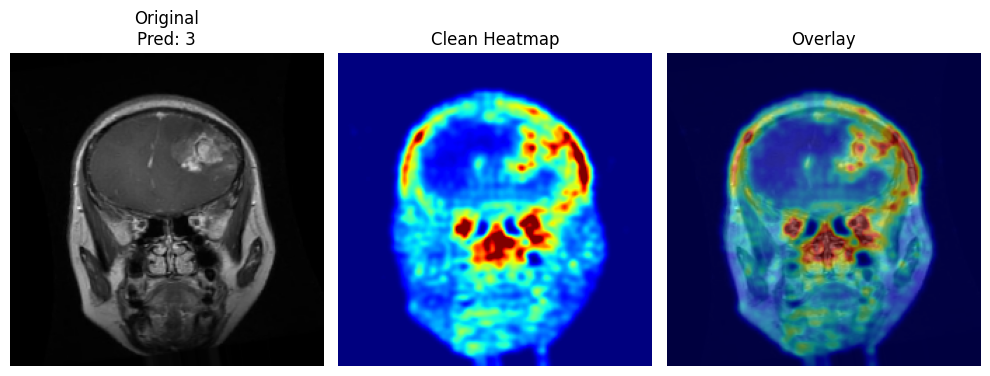

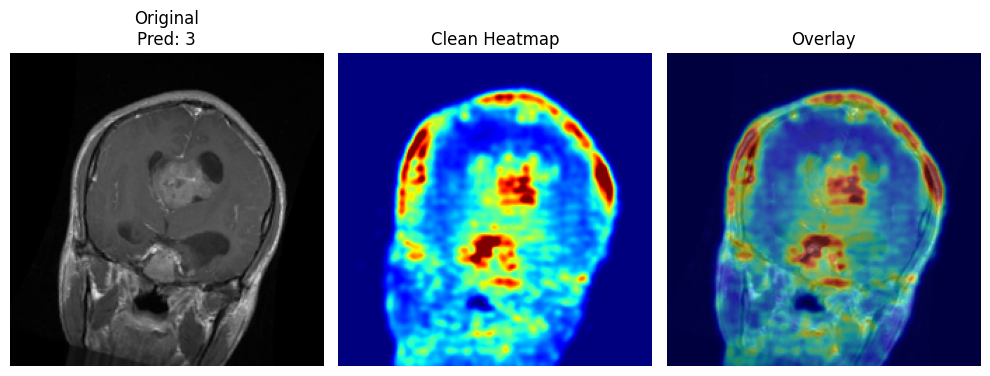

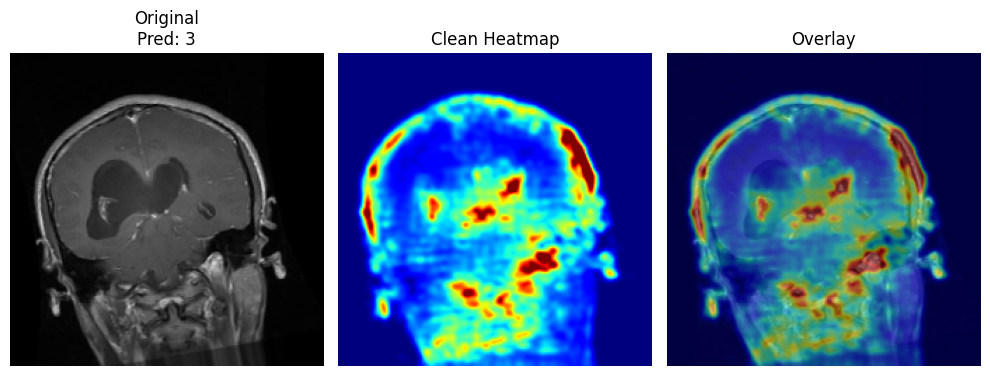

In [44]:
explain_smoothgrad_clean(firefly_model, val_gen, num_samples=3)

# Visualize GradCam

Running Logits Grad-CAM (The 'Nuclear Option' for 100% Confidence)...
Targeting Layer: Conv_1


/tmp/ipykernel_55/3616688361.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_heatmap = cm.get_cmap("jet")(np.arange(256))[:, :3][heatmap_uint8]


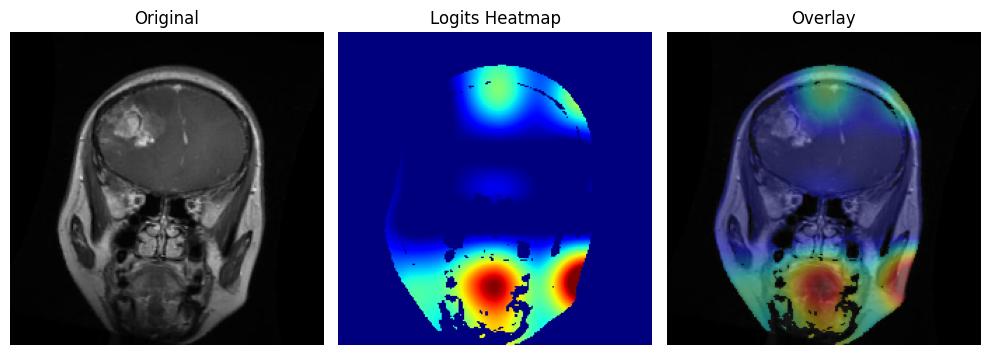

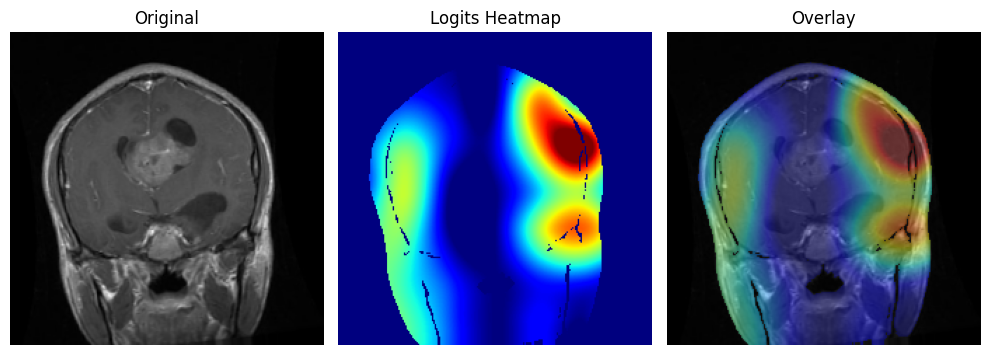

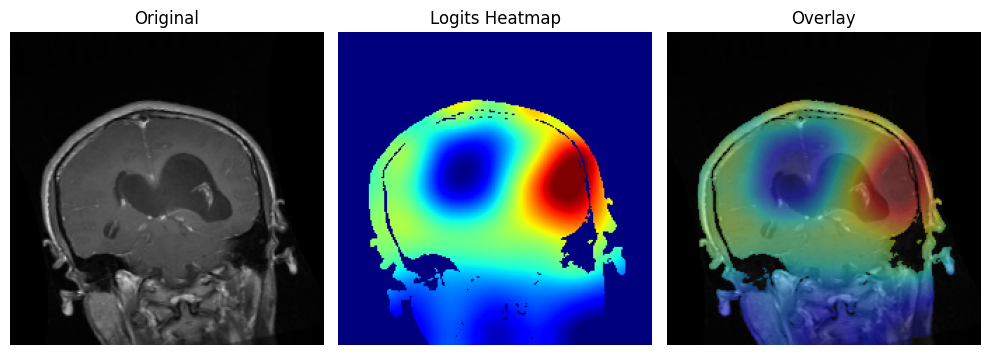

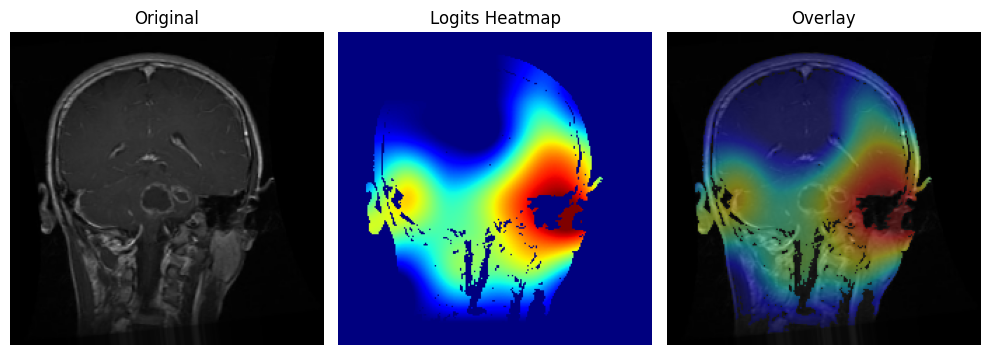

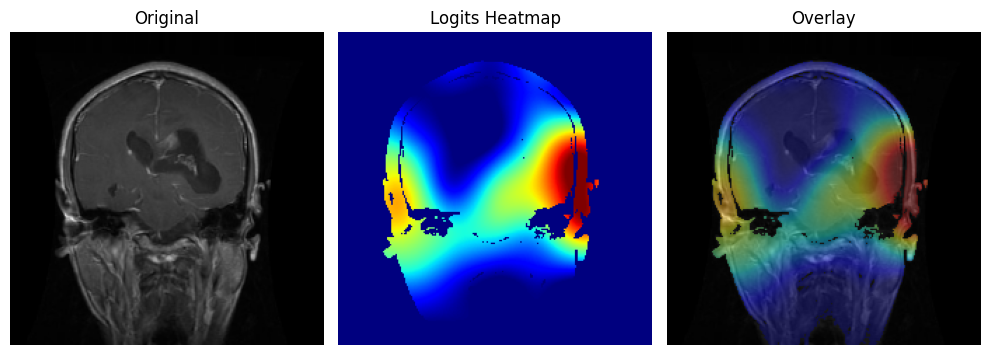

In [45]:
explain_gradcam_logits(firefly_model, val_gen, num_samples=5)